Changed:
```
 -> import pyro.distributions as dist
NSIM = 1000 -> NSIM = 10
post = swyft.Posteriors.load(net).to(DEVICE) -> post = swyft.Posteriors.load(net).to('cuda')
```

In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)

from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML
import pyro.distributions as dist

import swyft

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

In [2]:
SYSTEM_NAME = "ngc4414"
NSIM = 1000
SIM_PATH = f'store.zarr' 

SIGMA = 0.1

### Utilities

In [3]:
def get_config(system_name: str) -> Clipppy:
    """
    Get configuration
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

    SOURCE_DIR = '../../mock_data/sources'
        
    source_name = f'{system_name}.npy'
    config = load_config('config-sub.yaml', base_dir=SOURCE_DIR)

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return config


def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    return swyft.Prior(lambda u: (highs - lows) * u + lows, 2)


def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    # Upsample image
    upsample = 10
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
    x_sub, y_sub = np.squeeze(v.T)
    d_p_sub = dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)

    def _guide():
        # Sample subhalo position
        guide_sample = {
            "main/sub/p_sub": pyro.sample("main/sub/p_sub", d_p_sub),
        }

        return guide_sample
    
    result = {
        "image": CONFIG.ppd(guide=_guide)["model_trace"]
        .nodes["mu"]["value"]
        .detach()
        .numpy()
    }
    
    # Restore coarse grid
    config.umodel.coerce_XY(X, Y)
    # Downsample image
    averager = torch.nn.AvgPool2d((upsample, upsample))
    result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

def noise(obs, _=None, sigma_n=SIGMA):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}

### Check utilities

In [4]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(SYSTEM_NAME)
torch.set_default_tensor_type(torch.FloatTensor)

/home/eliasd/lensing/clipppy/src/clipppy/yaml/constructor.py:56: FutureWarning: Using '__args' for parameter expansion is deprecated and will soon be considered an ordinary keyword argument. Consider using '<' instead.
  warn('Using \'__args\' for parameter expansion is deprecated'


In [5]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
torch.set_default_tensor_type(torch.FloatTensor)

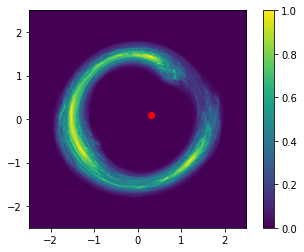

In [6]:
v = torch.tensor([0.3, 0.1])
plt.imshow(simul(v, CONFIG)['image'], **imkwargs)
plt.scatter(*v.t(), c="r")
plt.colorbar()

### Simulate

In [7]:
prior = get_prior(CONFIG)
nx = CONFIG.kwargs["defs"]["nx"]
ny = CONFIG.kwargs["defs"]["ny"]

In [8]:
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
                            pnames = ["x_sub", "y_sub"],
                            sim_shapes={"image": (nx, ny)})

store = swyft.DirectoryStore(path=SIM_PATH, simulator=simulator)
 
store.add(NSIM, prior)
store.simulate()

Loading existing store.
Store: Adding 912 new samples to simulator store.


### Check store

In [9]:
store = swyft.DirectoryStore(path=SIM_PATH)
len(store)

Loading existing store.


1006

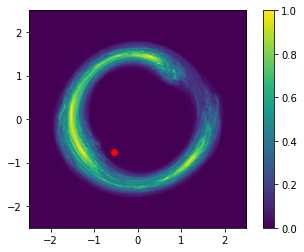

In [10]:
idx = 1
plt.imshow(store[idx][0]['image'], **imkwargs)
plt.scatter(*store[idx][1], c="r")
plt.colorbar()

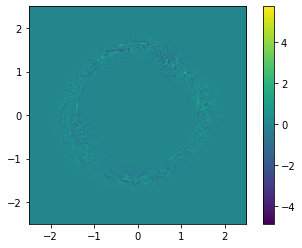

In [11]:
plt.imshow(store[1][0]['image']-store[-1][0]['image'], **imkwargs)
plt.colorbar()

### Train

In [12]:
class DownsampleLinearHead(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        image_shape = obs_shapes["image"]
        self.onl_f = swyft.networks.OnlineNormalizationLayer(
            image_shape, use_average_std=False
        )

        self.factor = 8
        downscaled_image_shape = (
            image_shape[0] // self.factor,
            image_shape[1] // self.factor,
        )
        self.avg2d = torch.nn.AvgPool2d((self.factor, self.factor))

        self.n_features = 8
        self.layers = torch.nn.Linear(np.prod(downscaled_image_shape), self.n_features)

    def forward(self, obs):
        x = obs["image"]
        nbatch = len(x)
        x = self.onl_f(x)
        x = self.avg2d(x.unsqueeze(1)).squeeze(1)
        x = self.layers(x.view(nbatch, -1))
        return x

In [13]:
dataset = swyft.Dataset(NSIM, prior, store, simhook = noise)
post = swyft.Posteriors(dataset)

In [14]:
marginals = [(0, 1)]  #, (0,), (1,)]
post.add(
        marginals,
        head=DownsampleLinearHead,
        device="cuda",
    )

post.train(marginals)

Training: lr=0.001, Epoch=11, VL=0.2488


In [15]:
net = 'net.pt'
post.save(net)

### Check posteriors

In [16]:
post = swyft.Posteriors.load(net).to('cuda')

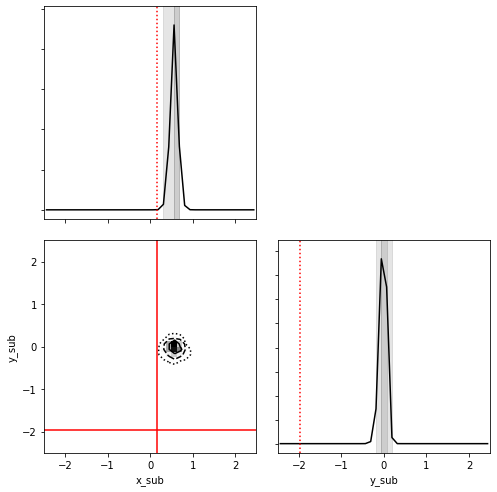

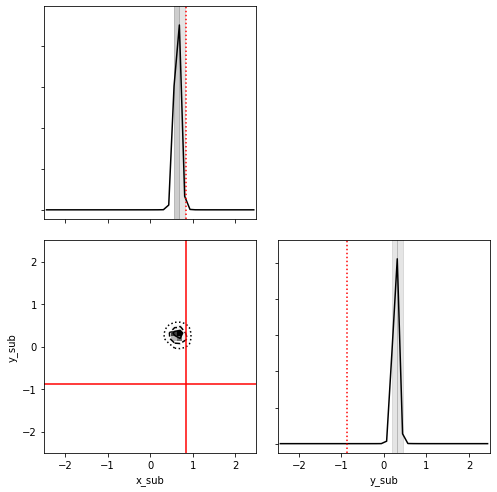

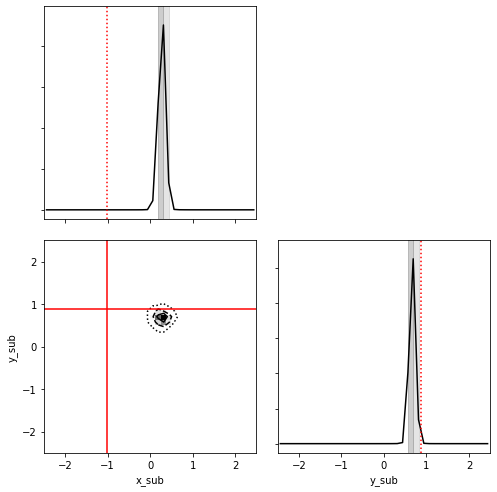

In [25]:
for idx in range(2, 5):
    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
#     idx = 5 # choose different observation 
    IMAGE = store[idx][0]["image"]
    v0 = store[idx][1]
    samples = post.sample(100000, {"image": IMAGE})

    swyft.plot_corner(
        samples, 
        [0, 1], 
        color='k', 
        figsize = (8,8), 
        truth=v0, 
        bins = 40);

    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK